In [208]:
import pandas as pd
import metrics
import numpy as np
import custom_metrics

In [209]:
metrics = ["NDCG@10", "MAP@10", "Recall@10", "P@10", "MRR@10"]
model_names = ["deepseek"]
prompt_names = ["true", "bing", "gemini", "grok", "gemini_fact", "grok_fact"]

# Промпты

* true – переведен оригинальный `TRUE`
* bing – переведенная структура оригинального `UMBRELLA`, но изменены критерии релевантности
* название модели – промнт сгенерирован LLM на основании мета-промпта `prompt_prompt`
* название модели + fact – промнт сгенерирован LLM на основании мета-промпта `prompt_prompt_fact`

Различия `prompt_prompt` и `prompt_prompt_fact`
* `prompt_prompt` – использует более общие критерии релевантности
* `prompt_prompt_fact` – критерии релевантности строго как описано в статье, именно подтверждение фактов

In [210]:
judgment_datas = {f"{model}_{prompt}": pd.read_csv(f"rerank_{model}_{prompt}.tsv", sep="\t") for model in model_names for prompt in prompt_names}

In [211]:

metrics_datas = {key: custom_metrics.MetricsEvaluator(value) for key, value in judgment_datas.items()}

In [212]:
e5 = {
    "NDCG@1": 0.57491,
    "NDCG@3": 0.5239,
    "NDCG@5": 0.48212,
    "NDCG@10": 0.45518,
    "NDCG@100": 0.53363,
    "MAP@1": 0.08363,
    "MAP@3": 0.20745,
    "MAP@5": 0.25387,
    "MAP@10": 0.30273,
    "MAP@100": 0.35444,
    "Recall@1": 0.08363,
    "Recall@3": 0.22008,
    "Recall@5": 0.28973,
    "Recall@10": 0.39123,
    "Recall@100": 0.63855,
    "P@1": 0.58614,
    "P@3": 0.51561,
    "P@5": 0.42472,
    "P@10": 0.3,
    "P@100": 0.05425,
    "MRR@1": 0.58614,
    "MRR@3": 0.63483,
    "MRR@5": 0.65159,
    "MRR@10": 0.66281,
    "MRR@100": 0.66685
}
reranker = {
    "NDCG@1": 0.68633,
    "NDCG@3": 0.63545,
    "NDCG@5": 0.58062,
    "NDCG@10": 0.52669,
    "NDCG@100": 0.5172,
    "MAP@1": 0.09994,
    "MAP@3": 0.25653,
    "MAP@5": 0.31406,
    "MAP@10": 0.36613,
    "MAP@100": 0.38419,
    "Recall@1": 0.09994,
    "Recall@3": 0.26886,
    "Recall@5": 0.3474,
    "Recall@10": 0.43776,
    "Recall@100": 0.48185,
    "P@1": 0.69288,
    "P@3": 0.62921,
    "P@5": 0.51011,
    "P@10": 0.33783,
    "P@100": 0.03848,
    "MRR@1": 0.69288,
    "MRR@3": 0.73502,
    "MRR@5": 0.74831,
    "MRR@10": 0.75179,
    "MRR@100": 0.75249
}

In [213]:
def gen_table():
  num_models = len(model_names)
  metric_names = metrics
  multy_index = [
    [metric for metric in metric_names for _ in range(num_models)],
    [model for _ in range(len(metric_names)) for model in model_names]
  ]
  columns_num = len(multy_index[0])
  lines = []
  for prompt in prompt_names:
    prompt_res = np.zeros(num_models*len(metric_names), dtype=np.float64)
    for i in range(columns_num):
      model = multy_index[1][i]
      metric = multy_index[0][i]
      prompt_res[i] = metrics_datas[f"{model}_{prompt}"][metric]
    lines.append(prompt_res)
  lines.insert(0, [e5[multy_index[0][i]] for i in range(columns_num)])
  lines.insert(1, [reranker[multy_index[0][i]] for i in range(columns_num)])
  columns = pd.MultiIndex.from_arrays(multy_index, names=['Метрика', 'llm'])
  return pd.DataFrame(
    lines,
    columns=columns,
    index=["e5-large", "BGE"]+prompt_names
  )
tb = gen_table()
def highlight_index(row):
    if row.name == "e5-large":
        return ['font-style: italic;'] * len(row)
    return [''] * len(row)



tb.style.apply(highlight_index, axis=1).highlight_max(subset=tb.columns, props='font-weight: bold')


Метрика,NDCG@10,MAP@10,Recall@10,P@10,MRR@10
llm,deepseek,deepseek,deepseek,deepseek,deepseek
e5-large,0.455180,0.302730,0.391230,0.300000,0.662810
BGE,0.526690,0.366130,0.437760,0.337830,0.751790
true,0.631650,0.546200,0.727740,0.300560,0.764750
bing,0.653810,0.572060,0.746790,0.308240,0.772010
gemini,0.643020,0.559030,0.725390,0.297940,0.766360
grok,0.639530,0.559170,0.724190,0.299060,0.758470
gemini_fact,0.649430,0.567630,0.718410,0.294760,0.755530
grok_fact,0.648440,0.566860,0.711650,0.291390,0.772030


# Пояснение

* NDCG поломанный так как 1. модель возвращает класс релевантности 0-2, 2. существенный дисбаланс классов релевантности в пользу 1 и вообще нет 0;
* Все остальные метрики очень низки;

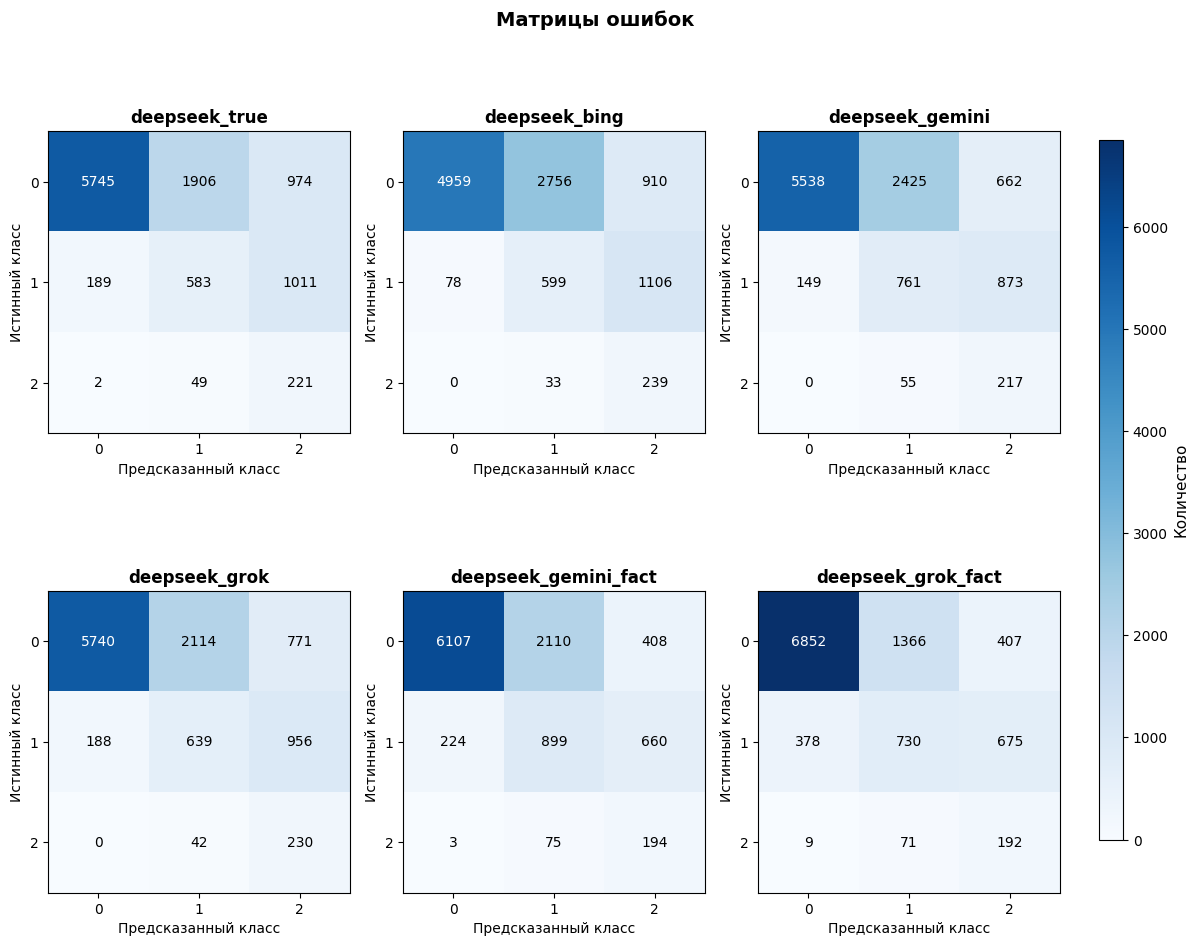

In [214]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
def plot_multiple_confusion_matrices(datasets: dict[str, any], num_classes=3, normalize=False):
    fig, axes = plt.subplots(2, 3, figsize=(12, 10))
    axes = axes.ravel()
    
    all_classes = [i for i in range(num_classes)]
    
    all_matrices = {}
    for data_name, data in datasets.items():
        llm = data["llm-score"].to_numpy(int)
        human = data["human-score"].to_numpy(int)
        cm_matrix = confusion_matrix(human, llm, labels=all_classes)
        
        if normalize:
            cm_matrix = cm_matrix.astype('float')
            row_sums = cm_matrix.sum(axis=1)[:, np.newaxis]
            row_sums[row_sums == 0] = 1
            cm_matrix = cm_matrix / row_sums
        
        all_matrices[data_name] = cm_matrix
    
    vmax = max([matrix.max() for matrix in all_matrices.values()])
    
    from matplotlib.cm import ScalarMappable
    from matplotlib.colors import Normalize
    norm = Normalize(vmin=0, vmax=vmax)
    
    for idx, (data_name, cm_matrix) in enumerate(all_matrices.items()):
        ax = axes[idx]
        
        im = ax.imshow(cm_matrix, cmap='Blues', norm=norm)
        
        for i in range(cm_matrix.shape[0]):
            for j in range(cm_matrix.shape[1]):
                text = f'{cm_matrix[i, j]:.2f}' if normalize else f'{int(cm_matrix[i, j])}'
                color = 'white' if cm_matrix[i, j] > vmax/2 else 'black'
                ax.text(j, i, text, ha='center', va='center', 
                       color=color, fontsize=10)
        
        ax.set_title(data_name, fontsize=12, fontweight='bold')
        ax.set_xticks(range(num_classes))
        ax.set_yticks(range(num_classes))
        ax.set_xticklabels(all_classes)
        ax.set_yticklabels(all_classes)
        
        ax.set_xlabel('Предсказанный класс', fontsize=10)
        ax.set_ylabel('Истинный класс', fontsize=10)
    
    plt.tight_layout(rect=[0, 0, 0.9, 0.95])
    
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    sm = ScalarMappable(norm=norm, cmap='Blues')
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label('Доля' if normalize else 'Количество', fontsize=11)
    
    fig.suptitle('Матрицы ошибок', fontsize=14, fontweight='bold')
    plt.show()

plot_multiple_confusion_matrices(judgment_datas, normalize=False)

# Пояснения

* Опять же виден перевес класса 1;
* Основная путаница между (1 и 0) и (1 и 2);
* Промпты fact более строги к ответам, больше всего ответов попадает в 0;

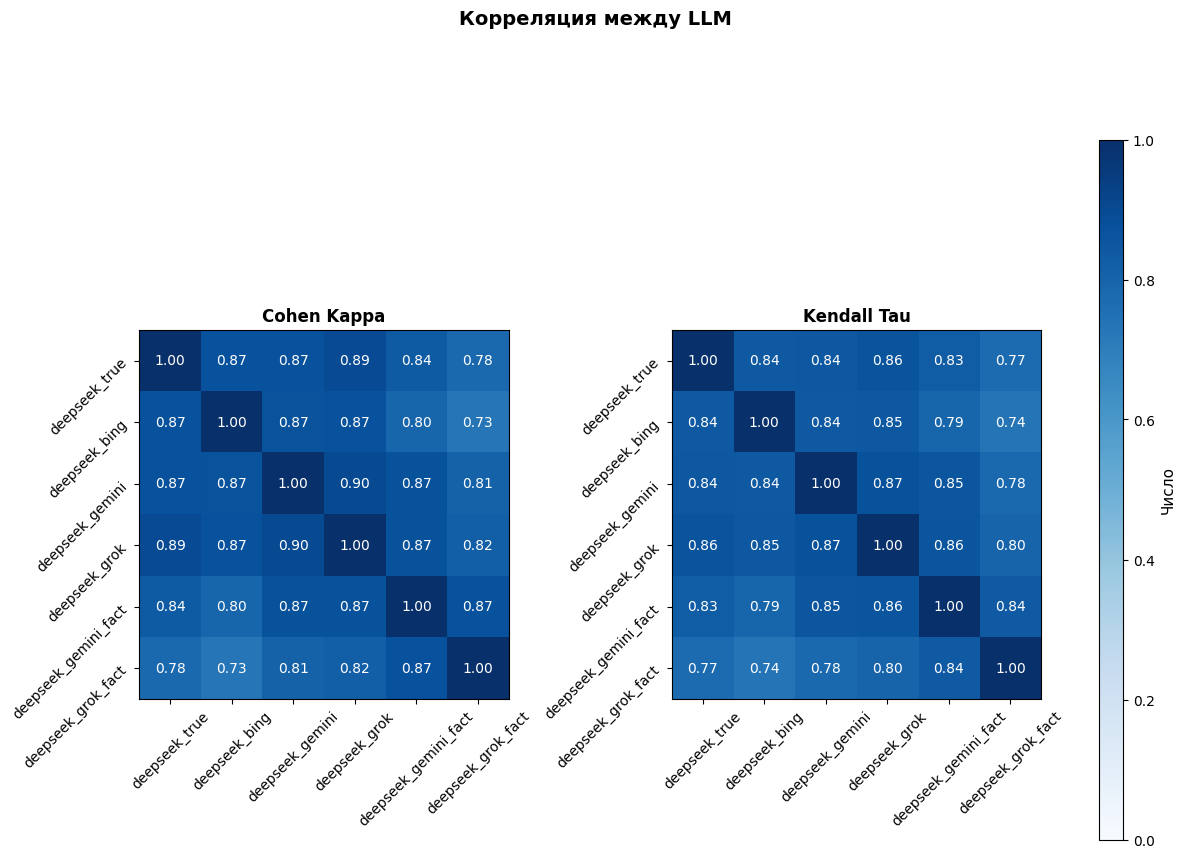

In [215]:
import metrics
def plot_multiple_corr_matrices(datasets: dict[str, any], corr_metrics: dict[str:any], normalize=False):
    fig, axes = plt.subplots(1, 2, figsize=(12, 10))
    axes = axes.ravel()
    
    
    all_matrices = {}
    for metric_name, metric in corr_metrics.items():
      data = [data for _, data in datasets.items()]
      labels = [data_name for data_name, _ in datasets.items()]
      matrix = [[0 for _ in data] for _ in data]
      for i, data1 in enumerate(data):
          for j, data2 in enumerate(data):
              llm1 = data1["llm-score"].to_numpy(int)
              llm2 = data2["llm-score"].to_numpy(int)
              matrix[i][j] = metric(llm1, llm2)
      matrix = np.array(matrix)
      if normalize:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
        matrix = np.nan_to_num(matrix)
          
      all_matrices[metric_name] = (labels, matrix)
    
    vmax = max([matrix.max() for _, matrix in all_matrices.values()])
    
    from matplotlib.cm import ScalarMappable
    from matplotlib.colors import Normalize
    norm = Normalize(vmin=0, vmax=vmax)
    
    for idx, (data_name, (labels, matrix)) in enumerate(all_matrices.items()):
        ax = axes[idx]
        im = ax.imshow(matrix, cmap='Blues', norm=norm)
        for i in range(matrix.shape[0]):
            for j in range(matrix.shape[1]):
                text = f'{matrix[i, j]:.2f}'
                color = 'white' if matrix[i, j] > vmax/2 else 'black'
                ax.text(j, i, text, ha='center', va='center', 
                       color=color, fontsize=10)
        
        ax.set_title(data_name, fontsize=12, fontweight='bold')
        ax.set_xticks(range(len(labels)))
        ax.set_yticks(range(len(labels)))
        ax.set_xticklabels(labels, rotation=45)
        ax.set_yticklabels(labels, rotation=45)
        
    
    plt.tight_layout(rect=[0, 0, 0.9, 0.95])
    
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    sm = ScalarMappable(norm=norm, cmap='Blues')
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label('Число', fontsize=11)
    
    fig.suptitle('Корреляция между LLM', fontsize=14, fontweight='bold')
    plt.show()
corr_metrics = {
    "Cohen Kappa": metrics.cohen_kappa_metric,
    "Kendall Tau": metrics.kendall_metric
}
plot_multiple_corr_matrices(judgment_datas, corr_metrics)

# Пояснения

* высокая корреляция между llm с разными промптами;
* ожидаемо корреляция чуть выше, когда промпты были сгенерированы при помощи одно и того же промпта;

In [216]:
"""LLM:  2.0 HUMAN:  0.0 ID:  203.0
Query:  Джанет Джексон могла стать профессиональным жокеем, если бы не первая любовь.
Passage:  Однако рождённая в семье профессиональных музыкантов Джанет Джексон, чья любовь к лошадям выросла в желание стать профессиональным жокеем, не испытывала никакой тяги к индустрии развлечений. Несмотря на это, её отец решил вопрос карьеры дочери за неё. Позже она призналась, что «никто меня не спрашивал, хочу ли я заниматься шоу-бизнесом… это было ожидаемо».
LLM:  2.0 HUMAN:  0.0 ID:  0.0
Query:  Дядя Булгакова так и не узнал, что является прототипом профессора Преображенского.
Passage:  Пётр Иванович Булгаков — дядя, священник, автор коротких рассказов («Лукавый» и др.). Михаил Михайлович Покровский (1882—1943) — дядя, врач-терапевт. Николай Михайлович Покровский (1878—1942) — дядя, врач-гинеколог, основной прототип профессора Филиппа Филипповича Преображенского из повести «Собачье сердце».
LLM:  2.0 HUMAN:  0.0 ID:  400.0
Query:  Польские власти изъяли у России жилой комплекс (на илл.).
Passage:  Утром 11 апреля 2022 года к дому прибыли судебные исполнители с требованием передать его польской госказне в лице мэрии Варшавы. На место приехал заведующий консульским отделом посольства России, который заявил, что здание является объектом российской дипломатической недвижимости, и российская сторона не даёт согласия на его захват. Однако протест был проигнорирован.
LLM:  2.0 HUMAN:  0.0 ID:  368.0
Query:  Пастернак перед смертью исповедался скрябинской девочке.
Passage:  На обложке рукописи сохранилась сделанная его рукой надпись — «Проза Кати». 2 мая Пастернак рассказал сыну, что накануне к нему приходила «Катя Крашенинникова и я ей исповедался, она приготовила меня к смерти». Крашенинникова передала исповедь своему духовнику священнику Николаю Голубцову.
LLM:  2.0 HUMAN:  0.0 ID:  119.0
Query:  В XVII веке индийские христиане торжественно поклялись не подчиняться Римскому престолу.
Passage:  Действия латинских иерархов привели к тому, что в 1653 году группа местных христиан поклялись у поклонного креста в Маттанчери никогда не покоряться Ватикану и порвали с Католической церковью, вступив в общение с Сиро-яковитской церковью. В 1661 году папа Александр VII направил делегацию кармелитов во главе с халдейскими католиками, чтобы восстановить восточно-сирийские обряды под восточно-католической иерархией. К следующему году большинство общин (72 %) вернулись в общение со Святым Престолом, образовав Сиро-малабарскую католическую церковь.
LLM:  2.0 HUMAN:  0.0 ID:  198.0
Query:  Двое украинцев провозгласили в своём селе суверенное государство и выдавали его паспорта односельчанам.
Passage:  «Государство титульного суверенного народа Украины» (укр. Государство титульного суверенного народу Украіни), более известное как «Титульный суверенный народ Украины» (укр. Титульний суверенний народ Украіни, ТСНУ) — виртуальное государство, провозглашённое в селе Бакаевка Черниговской области Украины, действующее в Чернигове и занимавшееся преимущественно выдачей документов собственного образца. Деятельность ТСНУ выпускало банкноты, а также выдавало различные документы собственного образца — водительские удостоверения, номерные знаки автомобилей, паспорта и другие. ТСНУ утверждало, что обладатели паспорта ТСНУ, называемого «паспортом коренного народа Украины» и продаваемого в 2016 году за 600 гривен, якобы получают иммунитет от преследования судебными органами Украины и освобождаются от уплаты налогов и коммунальных платежей.
LLM:  2.0 HUMAN:  0.0 ID:  305.0
Query:  Муравьи одного из южноамериканских видов (на илл.) жертвуют собой по ночам.
Passage:  Обитают в Южной Америке. Обладают фактически суицидальным поведением, когда группа рабочих запечатывает на ночь своё гнездо, оставаясь после этого снаружи и обрекая себя на гибель. Описание Муравьи мелких размеров желтовато-коричневого цвета (около 2 мм).
LLM:  2.0 HUMAN:  0.0 ID:  270.0
Query:  Коммунисты Англии шли своим «Путём к социализму».
Passage:  В феврале 1951 года был опубликован первый проект новой программы КПВ, получившей название «Путь Британии к социализму» (The British Road to Socialism). Известно, что руководство КПВ при составлении документа обратилось за помощью к ВКП(б) и в разработке программы принял участие лично Иосиф Сталин, который видел эту программу «по своей сути» как «подходящий документ для коммунистических партий США, Канады, Австралии и других англо-саксонских стран». Авторству Сталина атрибутируются положения о народно-демократическом фронте, свободной ассоциации народов Британской империи на основе права на самоопределение, а также о тактике КПВ по отношению к Лейбористской партии.
LLM:  2.0 HUMAN:  0.0 ID:  85.0
Query:  Автору «Энеиды» приписывают поэму про комара.
Passage:  Небольшая поэма «Комар», согласно Светонию, была написана Публием в возрасте шестнадцати лет (по мнению некоторых исследователей, самая поздняя из возможных датировок — середина 44 года до н. э.). Её герой — пастух, который засыпает на солнцепёке, не видя, как к нему ползёт гадюка. Комар жалит пастуха, тот просыпается, убивает комара и замечает змею.
LLM:  2.0 HUMAN:  0.0 ID:  156.0
Query:  В ходе Войны за независимость в 1920 году был сожжён центр второго по размерам города Ирландии (на илл.).
Passage:  Так, в ответ на действия ИРА 11 декабря 1920 года, отряд «чёрно-пегих» (Особый резерв Королевской ирландской полиции) сжёг центральную часть Корка. Пока на юге и в центре Ирландии шла партизанская война, 10 марта 1920 года совет ольстерских националистов провёл голосование в Белфасте, по которому страна разделялась на два суверенных государства с собственными парламентами — на Северную и Южную Ирландию. 21 июля того же года между сторонниками партии «Шинн Фейн» и ольстерскими националистами произошли вооружённые столкновения в Белфасте."""


'LLM:  2.0 HUMAN:  0.0 ID:  203.0\nQuery:  Джанет Джексон могла стать профессиональным жокеем, если бы не первая любовь.\nPassage:  Однако рождённая в семье профессиональных музыкантов Джанет Джексон, чья любовь к лошадям выросла в желание стать профессиональным жокеем, не испытывала никакой тяги к индустрии развлечений. Несмотря на это, её отец решил вопрос карьеры дочери за неё. Позже она призналась, что «никто меня не спрашивал, хочу ли я заниматься шоу-бизнесом… это было ожидаемо».\nLLM:  2.0 HUMAN:  0.0 ID:  0.0\nQuery:  Дядя Булгакова так и не узнал, что является прототипом профессора Преображенского.\nPassage:  Пётр Иванович Булгаков — дядя, священник, автор коротких рассказов («Лукавый» и др.). Михаил Михайлович Покровский (1882—1943) — дядя, врач-терапевт. Николай Михайлович Покровский (1878—1942) — дядя, врач-гинеколог, основной прототип профессора Филиппа Филипповича Преображенского из повести «Собачье сердце».\nLLM:  2.0 HUMAN:  0.0 ID:  400.0\nQuery:  Польские власти изъял

In [217]:
"""LLM:  1.0 HUMAN:  0.0 ID:  459.0
Query:  Самая успешная театральная постановка в истории основывается на радиоспектакле, созданном Агатой Кристи по просьбе королевы.
Passage:  Сотрудники радиовещательной компании BBC обратились к ней с вопросом, чем они могли бы порадовать её в праздничном эфире. Королева, большая поклонница Агаты Кристи, попросила создать постановку на основе её произведения. Представители компании созвонились с Кристи и предложили ей написать получасовую радиопьесу.
LLM:  1.0 HUMAN:  0.0 ID:  2.0
Query:  Шутер от первого лица по «Южному Парку», несмотря на плохой приём
критиков, стал одной из самых продаваемых игр для Nintendo 64
Passage:  Рецензии и оценки Приём South Park зависел от платформы, на которой она была выпущена. В целом, игра получила негативные отзывы критиков в версиях для ПК и PlayStation, в то время как версия для Nintendo 64 в целом получила смешанные и положительные отзывы критиков. Версии для PlayStation и PC получили плохой приём из-за плохой графики, визуальных эффектов и озвучки.
LLM:  1.0 HUMAN:  0.0 ID:  267.0
Query:  Книга о мобилизованной немецкой нации стала бестселлером в мобилизованной России.
Passage:  Или же в современной России воспринимают происходящее как исключительно российское явление». Примечания Литература Морозова В. Н. И вновь о Второй мировой войне (Рец. на кн.: Старгардт Н. Мобилизованная нация: Германия 1939–1945 / Н. Старгардт; пер. с англ. А. З. Колина; под ред. А. О. Захарова. — М.: КоЛибри, Азбука-Аттикус, 2023.
LLM:  1.0 HUMAN:  0.0 ID:  448.0
Query:  Рок-н-ролл, исполнявшийся известным киноперсонажем, улетел в космос (на илл.).
Passage:  Впоследствии «Space Oddity» перепели ряд музыкантов, несколько отметились упоминанием майора Тома в своих собственных песнях. В 2013 году широкое внимание общественности привлекла кавер-версия, спетая астронавтом Крисом Хэдфилдом; сделанный им музыкальный клип был первым, снятым в космосе. «Space Oddity» фигурирует во многих фильмах и телесериалах, в том числе в ленте «Невероятная жизнь Уолтера Митти» (2013), где является одним из двигателей сюжета.
LLM:  1.0 HUMAN:  0.0 ID:  18.0
Query:  На московском острове растёт восьмиметровая облепиха
Passage:  После вывоза песка остров стал зарастать деревьями, и на нём появились бобры. На острове широко распространена облепиха. Наиболее часто встречающиеся древесные породы — различные виды берёзы, ивы, клёна, ольхи и тополя.
LLM:  1.0 HUMAN:  0.0 ID:  133.0
Query:  В еврейской кухне фаршируют не только (на илл.) рыбу, а грибенес не имеет отношения к грибам, зато связан с гусями.
Passage:  В еврейской кулинарной традиции это блюдо преимущественно готовят из карпа, значительно реже из иных кошерных сортов рыбы, таких как щука, кефаль, сиг. В европейских странах распространены рецепты с фаршированной форелью, которые получили популярность и в странах СНГ. В Израиле получило распространение приготовление фаршированной рыбы также из лосося.
LLM:  1.0 HUMAN:  0.0 ID:  338.0
Query:  Норвежская игра, получившая премию Британской Академии в области видеоигр, была заблокирована в России, Германии и Франции.
Passage:  Игра получила премию Британской Академии в области видеоигр (BAFTA) в номинации «Игра, выходящая за пределы развлечений» (англ. Game Beyond Entertainment). На 2022 год продажи игры в сумме на всех платформах превысили 2 миллиона копий. = Всплеск популярности в России =
В январе 2022 года игра неожиданно приобрела вирусную популярность в России благодаря роликам в TikTok.
LLM:  1.0 HUMAN:  0.0 ID:  357.0
Query:  Основатель неофашистской мужской организации известен вирусным видео «Как делать куннилингус».
Passage:  Гэвин Майлз Макиннес (англ. Gavin Miles McInnes, род. 17 июля 1970, Хитчин, Хартфордшир) — британо-канадский писатель, комик, подкастер и праворадикальный политический комментатор, основатель неофашистской ультраправой мужской организации «Proud Boys», которая признана террористической группой в Канаде и Новой Зеландии. Биография Гэвин Майлз Макиннес родился 17 июля 1970 года в шотландской семье Джеймса и Лорин Макиннес в городе Хитчин, графство Хартфордшир на юго-востоке Англии.
LLM:  1.0 HUMAN:  0.0 ID:  403.0
Query:  Популярный в Японии кубический автомобиль (на илл.) в Европе покупали неохотно.
Passage:  К этому времени его продажи сильно упали: Versa продавалась в 22 раза лучше. Канадское подразделение Nissan объявило в своём посте в Twitter 9 мая 2014 года, что Cube был официально снят с продаж в Канаде. = Европа =

До большей части европейских рынков Cube добрался сильно позже японского и американского.
LLM:  1.0 HUMAN:  0.0 ID:  114.0
Query:  В 1992 году один нелегитимный орган власти Грузии добровольно передал свои полномочия другому.
Passage:  Совет завершил свою деятельность 16 октября 1992 года самороспуском. Примечания Литература Стивен Джонс. Georgia: a political history since independence (англ.)."""


'LLM:  1.0 HUMAN:  0.0 ID:  459.0\nQuery:  Самая успешная театральная постановка в истории основывается на радиоспектакле, созданном Агатой Кристи по просьбе королевы.\nPassage:  Сотрудники радиовещательной компании BBC обратились к ней с вопросом, чем они могли бы порадовать её в праздничном эфире. Королева, большая поклонница Агаты Кристи, попросила создать постановку на основе её произведения. Представители компании созвонились с Кристи и предложили ей написать получасовую радиопьесу.\nLLM:  1.0 HUMAN:  0.0 ID:  2.0\nQuery:  Шутер от первого лица по «Южному Парку», несмотря на плохой приём\nкритиков, стал одной из самых продаваемых игр для Nintendo 64\nPassage:  Рецензии и оценки Приём South Park зависел от платформы, на которой она была выпущена. В целом, игра получила негативные отзывы критиков в версиях для ПК и PlayStation, в то время как версия для Nintendo 64 в целом получила смешанные и положительные отзывы критиков. Версии для PlayStation и PC получили плохой приём из-за пло

In [218]:
all_dfs = [data for data in judgment_datas.values()]

masks = []
for df in all_dfs:
    mask = (df['llm-score'] == 1) & (df['human-score'] == 0)
    masks.append(mask)

combined_mask = masks[0]
for mask in masks[1:]:
    combined_mask = combined_mask & mask

res = all_dfs[0][combined_mask]
# res = judgment_datas["gemma3:4b_bing"]
corpus = pd.read_json("corpus.jsonl", lines=True)
queries = pd.read_json("queries.jsonl", lines=True)
corpus.set_index("_id", inplace=True)
queries.set_index("_id", inplace=True)
# for _, row in res.sample(10).iterrows():
#   print("LLM: ", row["llm-score"], "HUMAN: ", row["human-score"], "ID: ", row["query-id"])
#   print("Query: ", queries.loc[row["query-id"]]["text"])
#   print("Passage: ", corpus.loc[row["corpus-id"]]["text"])

# Вывод

Проведенный анализ выявил не просто расхождение в критериях оценки между LLM и человеческими аннотаторами, а фундаментальную неконсистентность человеческой разметки. Наблюдаются систематические ошибки трех типов: неоправданная либеральность (приписывание релевантности на основе тематического сходства), избыточная строгость (требование дословного соответствия) и полная логическая несогласованность.

В таких условиях использование человеческих оценок в качестве ground truth теряет валидность. Единственный содержательный вывод из проведенных экспериментов — высокая корреляция между различными LLM промптами (0.70-0.85), что свидетельствует о внутренней согласованности моделей при оценке релевантности.

Таким образом, более перспективным направлением представляется исследование взаимного согласия LLM и разработка метрик, основанных на консенсусе искусственных моделей, а не на проблематичных человеческих аннотациях.